In [33]:
from datasets import load_from_disk
import numpy as np
product_list=[]
number_of_products_to_select=5
amazon_train_test_valid_dataset_final= ds = load_from_disk('/home/oviya/NLP_Project/amazon_product_dataset')
for i in range(number_of_products_to_select):
    random_floats = np.random.randint(0,175382) 
    product_name=amazon_train_test_valid_dataset_final['test'][random_floats]["product_name"]
    product_list.append(product_name)
print(product_list)
# product_list
amazon_test=amazon_train_test_valid_dataset_final['test']
# print(amazon_test)
amazon_test_subset = amazon_test[:5]
# print(amazon_test_subset)

['Cocalaku Deep Hydrating Anti-Wrinkle Eye Cream, Deep moisturizing cream, Effective anti-wrinkle, Smooth fine lines, Improve dark circles and puffiness, Premium formula For Revitalize the eye skin 20g', 'ColorProof SuperRich Moisture Shampoo to Hydrate and Treat Damaged Hair, 10.1 oz', 'BESTOPE Premium Makeup Brushes Kabuki Makeup Brush Set Cosmetics Foundation Blending Blush Eyeliner Face Powder Brush Kit (10PCS Pink Sliver)', 'Mini UV Light for Gel Nails, UV Light for Nails ANYINS Nail Lamp Portable UV Nail Lamp 16W UV Lamp Professional UV Lamp for Gel Nails Innovative Nail Dryer for Nail Art（White）', '"Oxford" Desktop Appliance Holder W/Outlet Iron Blower']


In [22]:
from transformers import pipeline, AutoTokenizer

tokenizer =AutoTokenizer.from_pretrained('final_bart_model')

def summarize_reviews1(product_name):
    # Filter reviews based on product name
    reviews = []
    ratings ={"positive":0,
              "negative":0,
              "neutral":0}
    for dicts in amazon_train_test_valid_dataset_final:
        for item in amazon_train_test_valid_dataset_final[dicts]:
            if item.get('product_name') == product_name:
                reviews.append(item['text'])
                current_rating=item['rating']
                if current_rating == 5 or current_rating == 4:
                    ratings['positive']+=1
                elif current_rating == 1 or current_rating == 2:
                    ratings['negative']+=1
                elif current_rating == 3:
                    ratings['neutral']+=1
    
    print("ratings",ratings)
    # reviews = [item['text'] for item in amazon_train_test_valid_dataset_final['train'] if item.get('product_name') == product_name]
    # [item['product_name']  for dicts  in datasets for item in amazon_train_test_valid_dataset_final[dicts]  ]
    # title = [item['title'] for item in amazon_train_test_valid_dataset_final['train'] if item.get('product_name') == product_name]
    output=[]
    if not reviews:
        return "No reviews found for this product."

    reviews_text = " ".join(reviews)

    print(reviews_text)
    pipe = pipeline('summarization', model='final_bart_model', tokenizer=tokenizer)
    gen_kwargs= {'length_penalty':0.8,'num_beams':8 ,'max_length':128}

    if len(reviews_text) > 1024:
        max_chunk_size = 1024  # Adjust this value based on the model's maximum token limit
        chunks = [reviews_text[i:i+max_chunk_size] for i in range(0, len(reviews_text), max_chunk_size)]
        summaries = [pipe(chunk,**gen_kwargs, do_sample=False)[0]['summary_text'] for chunk in chunks]
        summaryall = " ".join(summaries)

        output.append(reviews_text) #here
        output.append(summaryall)

    else:
        output.append(reviews_text)
        summary = pipe(reviews_text,**gen_kwargs)[0]['summary_text']
        output.append(summary)
    return output ,ratings

# data=summarize_reviews1(global_selected_product)
# summary_of_reviews=data[0]
# print("summary: /n",summary_of_reviews[1])
# print("reviews",summary_of_reviews[0])

In [23]:
#setiment analyzer with roberta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer1 =AutoTokenizer.from_pretrained(MODEL)
model1=AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/oviya/anaconda3/envs/nlp/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
def sentiment_analyser(summary): #returns scores as dict and list
    input_text=tokenizer1(summary, return_tensors='pt',truncation=True ,max_length=512)
    output=model1(**input_text)
    scores=output[0][0].detach().numpy()
    scores= softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict, scores

In [27]:
from bert_score import score



def summarizer_analyzer(original_text,generated_summary):
    P, R, F1 = score([generated_summary], [original_text], lang='en', verbose=True)
    print(f"BERTScore Precision: {P.mean().item()}")
    print(f"BERTScore Recall: {R.mean().item()}")
    print(f"BERTScore F1: {F1.mean().item()}")
    return P.item(), R.item(), F1.item()


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy
def evaluation_metrics_for_sentiment_analyser(scores,ratings):

    # 0: negative, 1: neutral, 2: positive
    predicted_label =  scores.argmax()

    print(predicted_label)
    # ratings=data[1]
    predicted_sentiment = ['negative', 'neutral', 'positive'][predicted_label]
    true_labels = ['positive'] * ratings['positive'] + ['neutral'] * ratings['neutral'] + ['negative'] * ratings['negative']
    predicted_labels = [predicted_sentiment] * len(true_labels)  # Assuming the same sentiment for all reviews


    # Calculate metrics
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1s = f1_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1s)
    print("Accuracy:", accuracy)

    precision = round(precision, 3)
    recall = round(recall, 3)
    f1s = round(f1s, 3)
    accuracy = round(accuracy, 3)

    return precision,recall,f1s,accuracy

In [29]:
#Evaluation for sentiment analyser
def summary_vs_reviews(summary_of_reviews):
    senmitent_summary=sentiment_analyser(summary_of_reviews[1])
    senmitent_reviews=sentiment_analyser(summary_of_reviews[0])
    # print("ratings",data[1])
    print('senmitent_summary',senmitent_summary)
    print('senmitent_reviews',senmitent_reviews)

In [49]:
product_list=['Cocalaku Deep Hydrating Anti-Wrinkle Eye Cream, Deep moisturizing cream, Effective anti-wrinkle, Smooth fine lines, Improve dark circles and puffiness, Premium formula For Revitalize the eye skin 20g',
            'ColorProof SuperRich Moisture Shampoo to Hydrate and Treat Damaged Hair, 10.1 oz', 
            'BESTOPE Premium Makeup Brushes Kabuki Makeup Brush Set Cosmetics Foundation Blending Blush Eyeliner Face Powder Brush Kit (10PCS Pink Sliver)', 
            '17 Pcs Fashion Macaron Hair Clips for Women 2020 Graduation Gifts for Her Girls Sunshine Hair Barettes Sweetness Hairpins Hair Accessories for Women Girls Party(17 Pcs)', 
            '"Oxford" Desktop Appliance Holder W/Outlet Iron Blower']

print(product_list)
summarizer_precision_lists=[]
summarizer_recall_lists=[]
summarizer_f1_lists=[]
sentiment_precision_lists=[]
sentiment_recall_lists=[]
sentiment_f1_lists=[]
sentiment_accuracy_lists=[]
rougue_lists=[]

for product_name in product_list: 
    summarizer_precision_list=[]
    summarizer_recall_list=[]
    summarizer_f1_list=[]
    sentiment_precision_list=[]
    sentiment_recall_list=[]
    sentiment_f1_list=[]
    sentiment_accuracy_list=[]
    rougue_list=[]
    data=summarize_reviews1(product_name)
    print("Product name",product_name)
    summary_of_reviews_and_reviews=data[0] # list of review text and summary in order and ratings
    print("reviews",summary_of_reviews_and_reviews[0])
    print("summary",summary_of_reviews_and_reviews[1])
    ratings=data[1]
    # print("product_name",product_name)
    # print("ratings",summary_of_reviews_and_reviews[1])
    
    dict_and_list_of_scores=sentiment_analyser(summary_of_reviews_and_reviews[1])
    print("dict_and_list_of_scores",dict_and_list_of_scores)
    
    #summarizer analysis
    values=summarizer_analyzer(summary_of_reviews_and_reviews[0],summary_of_reviews_and_reviews[1])
    
    #summarizer list updation
    summarizer_precision_list.append(values[0])
    summarizer_recall_list.append(values[1])
    summarizer_f1_list.append(values[2])
    
    # sentiment analysis
    print("dict_and_list_of_scores[1]",dict_and_list_of_scores[1])
    print("ratings",ratings)
    sentiment_values=evaluation_metrics_for_sentiment_analyser(dict_and_list_of_scores[1],ratings)
    rouguevals=calculate_rouge_scores(summary_of_reviews_and_reviews[0],summary_of_reviews_and_reviews[1])
    # sentiment list updation
    sentiment_precision_list.append(sentiment_values[0])
    sentiment_recall_list.append(sentiment_values[1])
    sentiment_f1_list.append(sentiment_values[2])
    sentiment_accuracy_list.append(sentiment_values[3])
    rougue_list.append(rouguevals)

    #updating the overall list
    summarizer_precision_lists.append(summarizer_precision_list)
    summarizer_recall_lists.append(summarizer_recall_list)
    summarizer_f1_lists.append(summarizer_f1_list)
    sentiment_precision_lists.append(sentiment_precision_list)
    sentiment_recall_lists.append(sentiment_recall_list)
    sentiment_f1_lists.append(sentiment_f1_list)
    sentiment_accuracy_lists.append(sentiment_accuracy_list)

    rougue_lists.append(rougue_list)

    print("rougue_scores",rougue_lists)







['Cocalaku Deep Hydrating Anti-Wrinkle Eye Cream, Deep moisturizing cream, Effective anti-wrinkle, Smooth fine lines, Improve dark circles and puffiness, Premium formula For Revitalize the eye skin 20g', 'ColorProof SuperRich Moisture Shampoo to Hydrate and Treat Damaged Hair, 10.1 oz', 'BESTOPE Premium Makeup Brushes Kabuki Makeup Brush Set Cosmetics Foundation Blending Blush Eyeliner Face Powder Brush Kit (10PCS Pink Sliver)', '17 Pcs Fashion Macaron Hair Clips for Women 2020 Graduation Gifts for Her Girls Sunshine Hair Barettes Sweetness Hairpins Hair Accessories for Women Girls Party(17 Pcs)', '"Oxford" Desktop Appliance Holder W/Outlet Iron Blower']
ratings {'positive': 3, 'negative': 0, 'neutral': 0}
The quality is great so far. From what I’ve researched you have to use the product on a consistent basis to see results. The consistency of the cream is smooth and hydrates your skin too. Love it ! Amazing product. Moisturizer the eyelids and under eye well. Only a tiny bit of produc

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 25.65 sentences/sec
BERTScore Precision: 0.955513060092926
BERTScore Recall: 0.889959454536438
BERTScore F1: 0.9215719699859619
dict_and_list_of_scores[1] [0.01751236 0.08038808 0.9020995 ]
ratings {'positive': 3, 'negative': 0, 'neutral': 0}
2
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
rougue_scores [[{'rouge1': Score(precision=1.0, recall=0.3482142857142857, fmeasure=0.5165562913907285), 'rouge2': Score(precision=0.9736842105263158, recall=0.3333333333333333, fmeasure=0.4966442953020134), 'rougeL': Score(precision=0.6153846153846154, recall=0.21428571428571427, fmeasure=0.31788079470198677)}]]
ratings {'positive': 94, 'negative': 13, 'neutral': 4}
Love this product! Crack for your hair!!! This is simply the best shampoo ever. You will notice an extreme change in the texture of your hair after 2-3 weeks of use. It also has the added benefit that it doesn't take much to get the job done. Like I have said before, the only down side of this product is th

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 6.97 sentences/sec
BERTScore Precision: 0.8679964542388916
BERTScore Recall: 0.8592227697372437
BERTScore F1: 0.8635873794555664
dict_and_list_of_scores[1] [0.00571389 0.01520129 0.97908485]
ratings {'positive': 94, 'negative': 13, 'neutral': 4}
2
Precision: 0.7171495820144469
Recall: 0.8468468468468469
F1 Score: 0.7766205229619864
Accuracy: 0.8468468468468469


/home/oviya/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rougue_scores [[{'rouge1': Score(precision=1.0, recall=0.3482142857142857, fmeasure=0.5165562913907285), 'rouge2': Score(precision=0.9736842105263158, recall=0.3333333333333333, fmeasure=0.4966442953020134), 'rougeL': Score(precision=0.6153846153846154, recall=0.21428571428571427, fmeasure=0.31788079470198677)}], [{'rouge1': Score(precision=0.9932049830124575, recall=0.21843088418430884, fmeasure=0.35810534912209063), 'rouge2': Score(precision=0.8990929705215419, recall=0.19755854509217738, fmeasure=0.323937908496732), 'rougeL': Score(precision=0.8708946772366931, recall=0.19153175591531757, fmeasure=0.3140057166190282)}]]
ratings {'positive': 15, 'negative': 1, 'neutral': 5}
Great quality brushes I love them!!! Amazing love these for there price they feel great!!! Super soft !!! I can say better than some of my mac and sephora brushes!! Loved the brushes The brushes are very smooth, but I don't ever use them all. Like it! Just got it today. It doesn't shed. And so soft!!!!!! They say 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.90 sentences/sec
BERTScore Precision: 0.8898560404777527
BERTScore Recall: 0.8496742248535156
BERTScore F1: 0.8693010210990906
dict_and_list_of_scores[1] [0.03226596 0.08079242 0.8869416 ]
ratings {'positive': 15, 'negative': 1, 'neutral': 5}
2
Precision: 0.5102040816326531
Recall: 0.7142857142857143
F1 Score: 0.5952380952380952
Accuracy: 0.7142857142857143
rougue_scores [[{'rouge1': Score(precision=1.0, recall=0.3482142857142857, fmeasure=0.5165562913907285), 'rouge2': Score(precision=0.9736842105263158, recall=0.3333333333333333, fmeasure=0.4966442953020134), 'rougeL': Score(precision=0.6153846153846154, recall=0.21428571428571427, fmeasure=0.31788079470198677)}], [{'rouge1': Score(precision=0.9932049830124575, recall=0.21843088418430884, fmeasure=0.35810534912209063), 'rouge2': Score(precision=0.8990929705215419, recall=0.19755854509217738, fmeasure=0.323937908496732), 'rougeL': Score(precision=0.8708946772366931, recall=0.19153175591531757, fmeasure=0.314005

/home/oviya/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ratings {'positive': 12, 'negative': 1, 'neutral': 0}
My granddaughter loved them WOW great price. I love this item so far, very cute of design, all colors are beautiful, the quality is great as well.I use it everyday,not too tie not too loose, it is perfect! Cheap, one of the clips broke right away on the spot. And it tough on hair , it pulls hair, because the surface of the clips is not smooth Bueno So much prettier in person!! I love them! Simple clip and pin makes it easy to use. Nice color and nice size Very elegant and nice to wear to different events. The way it looks in the picture, is the same way it is. Very very nice. And it’s sturdy as well, I dropped them and they stay together. Adorable but hard to stay in the hair. Very fun! These look great in an updo, or just a simple hairstyle. The clips arrived nicely packaged and they all look better in person. Highly recommend it! My hair accessories arrived very quickly.  There were pretty colored jewels that would go with quite a

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 19.27 sentences/sec
BERTScore Precision: 0.7508295774459839
BERTScore Recall: 0.7700678110122681
BERTScore F1: 0.7603269815444946
dict_and_list_of_scores[1] [0.00190641 0.14858368 0.8495099 ]
ratings {'positive': 12, 'negative': 1, 'neutral': 0}
2
Precision: 0.8520710059171598
Recall: 0.9230769230769231
F1 Score: 0.8861538461538461
Accuracy: 0.9230769230769231
rougue_scores [[{'rouge1': Score(precision=1.0, recall=0.3482142857142857, fmeasure=0.5165562913907285), 'rouge2': Score(precision=0.9736842105263158, recall=0.3333333333333333, fmeasure=0.4966442953020134), 'rougeL': Score(precision=0.6153846153846154, recall=0.21428571428571427, fmeasure=0.31788079470198677)}], [{'rouge1': Score(precision=0.9932049830124575, recall=0.21843088418430884, fmeasure=0.35810534912209063), 'rouge2': Score(precision=0.8990929705215419, recall=0.19755854509217738, fmeasure=0.323937908496732), 'rougeL': Score(precision=0.8708946772366931, recall=0.19153175591531757, fmeasure=0.31400

/home/oviya/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ratings {'positive': 22, 'negative': 6, 'neutral': 7}
Nice but the slots can be a bit bigger for curling irons Just what I was searching for! It is good heavy quality. Looks nice. Only gave this 4 stars because the smallest hole cannot hold any og my curling irons This thing works perfect for the events I have to travel too, its heavy enough that it doesn't move or flip when using, and also has a built in power bar that makes using multiple tools really convenient. This is a great product!  It's very heavy so it stays in place as you pull your items out and replace them.  High quality and would definitely buy again!! In love with this.. really helps keep everything organized. It’s heavy and sturdy when set on a flat surface and will hold up without being fastened down but the hair dryer holder was the only useful part of this stand. All of the inserts are plastic so you can’t keep your hot tools in there while using them and the holes are so small! I thought it would work because the d

Your max_length is set to 128, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Product name "Oxford" Desktop Appliance Holder W/Outlet Iron Blower
reviews Nice but the slots can be a bit bigger for curling irons Just what I was searching for! It is good heavy quality. Looks nice. Only gave this 4 stars because the smallest hole cannot hold any og my curling irons This thing works perfect for the events I have to travel too, its heavy enough that it doesn't move or flip when using, and also has a built in power bar that makes using multiple tools really convenient. This is a great product!  It's very heavy so it stays in place as you pull your items out and replace them.  High quality and would definitely buy again!! In love with this.. really helps keep everything organized. It’s heavy and sturdy when set on a flat surface and will hold up without being fastened down but the hair dryer holder was the only useful part of this stand. All of the inserts are plastic so you can’t keep your hot tools in there while using them and the holes are so small! I thought it wo

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.18 sentences/sec
BERTScore Precision: 0.8518620729446411
BERTScore Recall: 0.8562172651290894
BERTScore F1: 0.8540341258049011
dict_and_list_of_scores[1] [0.03309406 0.09601545 0.8708905 ]
ratings {'positive': 22, 'negative': 6, 'neutral': 7}
2
Precision: 0.39510204081632655
Recall: 0.6285714285714286
F1 Score: 0.4852130325814536
Accuracy: 0.6285714285714286
rougue_scores [[{'rouge1': Score(precision=1.0, recall=0.3482142857142857, fmeasure=0.5165562913907285), 'rouge2': Score(precision=0.9736842105263158, recall=0.3333333333333333, fmeasure=0.4966442953020134), 'rougeL': Score(precision=0.6153846153846154, recall=0.21428571428571427, fmeasure=0.31788079470198677)}], [{'rouge1': Score(precision=0.9932049830124575, recall=0.21843088418430884, fmeasure=0.35810534912209063), 'rouge2': Score(precision=0.8990929705215419, recall=0.19755854509217738, fmeasure=0.323937908496732), 'rougeL': Score(precision=0.8708946772366931, recall=0.19153175591531757, fmeasure=0.31400

/home/oviya/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
print("summarizer_precision_lists",summarizer_precision_lists)
print("summarizer_recall_lists",summarizer_recall_lists)
print("summarizer_f1_lists",summarizer_f1_lists)
print("sentiment_precision_lists",sentiment_precision_lists)
print("sentiment_recall_lists",sentiment_recall_lists)
print("sentiment_f1_lists",sentiment_f1_lists)
print("sentiment_accuracy_lists",sentiment_accuracy_lists)

summarizer_precision_lists [[0.955513060092926], [0.8679964542388916], [0.8898560404777527], [0.7508295774459839], [0.8518620729446411]]
summarizer_recall_lists [[0.889959454536438], [0.8592227697372437], [0.8496742248535156], [0.7700678110122681], [0.8562172651290894]]
summarizer_f1_lists [[0.9215719699859619], [0.8635873794555664], [0.8693010210990906], [0.7603269815444946], [0.8540341258049011]]
sentiment_precision_lists [[np.float64(1.0)], [np.float64(0.717)], [np.float64(0.51)], [np.float64(0.852)], [np.float64(0.395)]]
sentiment_recall_lists [[np.float64(1.0)], [np.float64(0.847)], [np.float64(0.714)], [np.float64(0.923)], [np.float64(0.629)]]
sentiment_f1_lists [[np.float64(1.0)], [np.float64(0.777)], [np.float64(0.595)], [np.float64(0.886)], [np.float64(0.485)]]
sentiment_accuracy_lists [[1.0], [0.847], [0.714], [0.923], [0.629]]


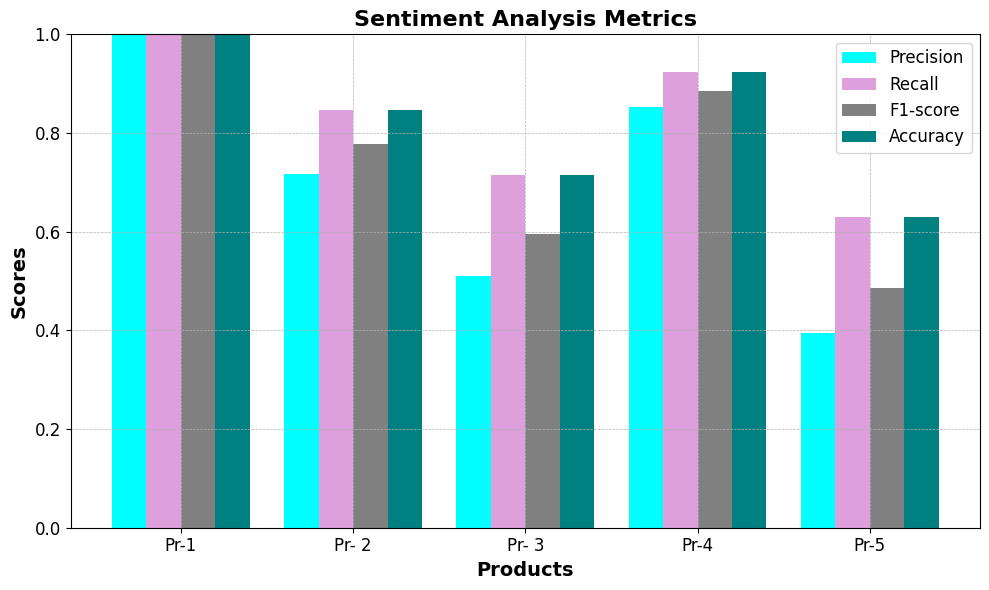

In [81]:
import matplotlib.pyplot as plt
import numpy as np


x_labels = ['Pr-1', 'Pr- 2', 'Pr- 3', 'Pr-4', 'Pr-5']

bar_width = 0.2
index = np.arange(len(x_labels))


plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, sentiment_precision_lists, bar_width, label='Precision', color='cyan')
bars2 = plt.bar(index + bar_width, sentiment_recall_lists, bar_width, label='Recall', color='plum')
bars3 = plt.bar(index + 2 * bar_width, sentiment_f1_lists, bar_width, label='F1-score', color='grey')
bars4 = plt.bar(index + 3 * bar_width, sentiment_accuracy_lists, bar_width, label='Accuracy', color='teal')


plt.xlabel('Products', fontsize=14,fontweight='bold')
plt.ylabel('Scores', fontsize=14,fontweight='bold')
plt.title('Sentiment Analysis Metrics', fontsize=16, fontweight='bold')  
plt.xticks(index + 1.5 * bar_width, x_labels, fontsize=12)  
plt.yticks(fontsize=12)
plt.ylim(0.0, 1.0)  
plt.legend(fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()


In [58]:
print(rougue_lists)

[[{'rouge1': Score(precision=1.0, recall=0.3482142857142857, fmeasure=0.5165562913907285), 'rouge2': Score(precision=0.9736842105263158, recall=0.3333333333333333, fmeasure=0.4966442953020134), 'rougeL': Score(precision=0.6153846153846154, recall=0.21428571428571427, fmeasure=0.31788079470198677)}], [{'rouge1': Score(precision=0.9932049830124575, recall=0.21843088418430884, fmeasure=0.35810534912209063), 'rouge2': Score(precision=0.8990929705215419, recall=0.19755854509217738, fmeasure=0.323937908496732), 'rougeL': Score(precision=0.8708946772366931, recall=0.19153175591531757, fmeasure=0.3140057166190282)}], [{'rouge1': Score(precision=0.9940828402366864, recall=0.2222222222222222, fmeasure=0.36324324324324325), 'rouge2': Score(precision=0.7857142857142857, recall=0.17483443708609273, fmeasure=0.28602383531960995), 'rougeL': Score(precision=0.7514792899408284, recall=0.167989417989418, fmeasure=0.27459459459459457)}], [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2

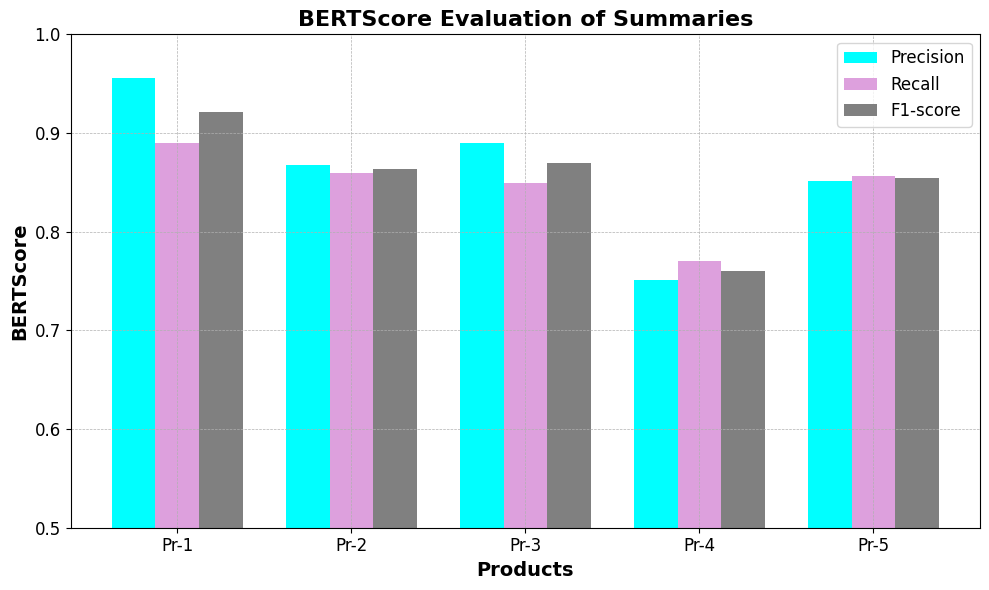

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the lists (assuming each sublist contains only one value)
precision_values = [val[0] for val in summarizer_precision_lists]
recall_values = [val[0] for val in summarizer_recall_lists]
f1_values = [val[0] for val in summarizer_f1_lists]

# Define x-axis labels
x_labels = ['Pr-1', 'Pr-2', 'Pr-3', 'Pr-4', 'Pr-5']

# Define bar width
bar_width = 0.25
index = np.arange(len(x_labels))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(index, precision_values, bar_width, label='Precision', color='cyan')
plt.bar(index + bar_width, recall_values, bar_width, label='Recall', color='plum')
plt.bar(index + 2 * bar_width, f1_values, bar_width, label='F1-score', color='grey')

# Add labels and title
plt.xlabel('Products',fontsize=14,fontweight='bold')
plt.ylabel('BERTScore',fontsize=14,fontweight='bold')
plt.title('BERTScore Evaluation of Summaries',fontsize=16,fontweight='bold')
plt.xticks(index + bar_width, x_labels,fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.5, 1.0)  # Set y-axis limits for better visualization
plt.legend(fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
